<a href="https://colab.research.google.com/github/my-tech123/Assignment-1-energy/blob/main/energy_regression_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Analysis of Linear, Ridge, Lasso, and Bayesian Regression
**Dataset:** `energydata_complete.csv` (UCI Appliances Energy Prediction)  
**Objective:** Predict `Appliances` energy use and compare Linear, Ridge, Lasso, and Bayesian regressions using R², RMSE, MAE.  
**Notebook style:** Educational — explanations, plots, and comments.


In [3]:
# Install required packages (uncomment the next line if running on a fresh Colab environment)
# !pip install -q scikit-learn pandas matplotlib seaborn nbformat

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print('Libraries loaded.')

Libraries loaded.


## 1) Download dataset
The cell below downloads the dataset directly from UCI and saves it locally as `energydata_complete.csv`.

In [4]:
# Download dataset from UCI directly into the notebook environment
url = "energydata_complete.csv"
df = pd.read_csv(url)
df.to_csv("energydata_complete.csv", index=False)
print('Dataset downloaded and saved as energydata_complete.csv')
df.head()

Dataset downloaded and saved as energydata_complete.csv


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## 2) Exploratory Data Analysis (EDA)

Shape: (19735, 29)

Columns:
 ['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']

Missing values per column:
 date          0
Appliances    0
lights        0
T1            0
RH_1          0
T2            0
RH_2          0
T3            0
RH_3          0
T4            0
dtype: int64


,Appliances
count,19735.000000
mean,97.694958
std,102.524891
min,10.000000
25%,50.000000
50%,60.000000
75%,100.000000
max,1080.000000


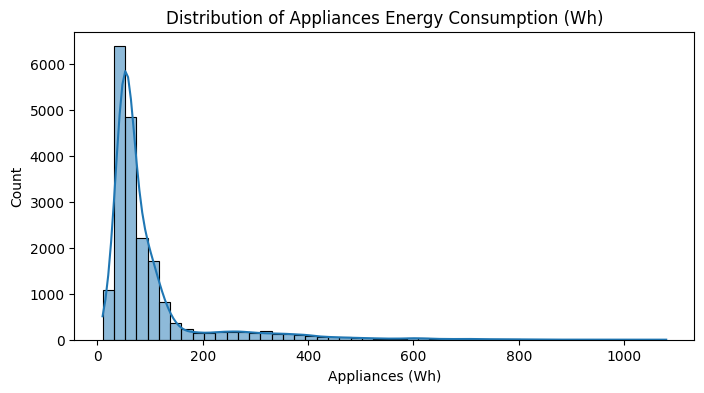

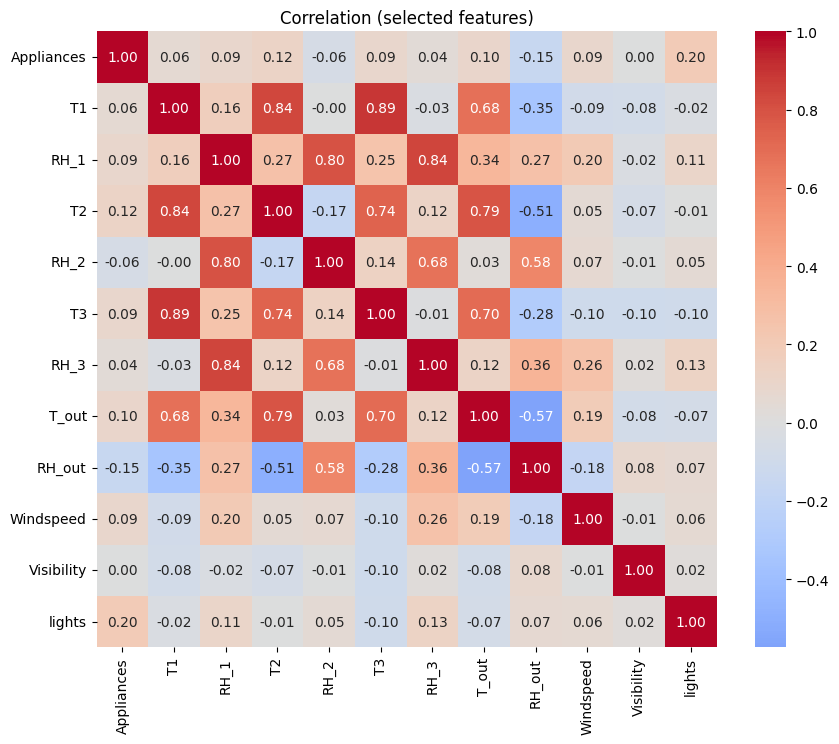

In [5]:
# Basic EDA
print('Shape:', df.shape)
print('\nColumns:\n', df.columns.tolist())
print('\nMissing values per column:\n', df.isnull().sum().sort_values(ascending=False).head(10))

# Quick statistical summary for target
display(df['Appliances'].describe())

# Plot distribution of target
plt.figure(figsize=(8,4))
sns.histplot(df['Appliances'], bins=50, kde=True)
plt.title('Distribution of Appliances Energy Consumption (Wh)')
plt.xlabel('Appliances (Wh)')
plt.show()

# Correlation heatmap (subset to save time)
cols = ['Appliances','T1','RH_1','T2','RH_2','T3','RH_3','T_out','RH_out','Windspeed','Visibility','lights']
plt.figure(figsize=(10,8))
sns.heatmap(df[cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation (selected features)')
plt.show()

## 3) Feature selection and preprocessing
We select a subset of features and standardize them before training.

In [6]:
# Feature selection
# We'll use a reasonable subset of predictors (you can expand this later)
features = ['T1','RH_1','T2','RH_2','T3','RH_3','T_out','RH_out','Windspeed','Visibility','lights']
target = 'Appliances'

X = df[features].copy()
y = df[target].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for Ridge/Lasso/Bayesian)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Training set:', X_train.shape, 'Test set:', X_test.shape)

Training set: (15788, 11) Test set: (3947, 11)


## 4) Train regression models
We'll train Linear, Ridge, Lasso, and Bayesian regressions.

In [7]:
# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'Bayesian Regression': BayesianRidge()
}

fitted = {}
preds = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    fitted[name] = model
    preds[name] = y_pred
    print(f'{name} trained.')

Linear Regression trained.
Ridge Regression trained.
Lasso Regression trained.
Bayesian Regression trained.


## 5) Evaluation
Compute R², RMSE, and MAE for each model.

In [8]:
# Evaluation metrics
results = []
for name, y_pred in preds.items():
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append([name, r2, rmse, mae])

results_df = pd.DataFrame(results, columns=['Model','R2','RMSE','MAE'])
# Round for readability
results_df[['R2','RMSE','MAE']] = results_df[['R2','RMSE','MAE']].round(4)
results_df.sort_values('R2', ascending=False, inplace=True)
results_df.style.background_gradient(subset=['R2'], cmap='Greens')

,Model,R2,RMSE,MAE
3,Bayesian Regression,0.133700,93.105700,55.050000
0,Linear Regression,0.133600,93.113400,55.068800
1,Ridge Regression,0.133600,93.112300,55.066300
2,Lasso Regression,0.133600,93.113000,55.067800


## 6) Coefficients visualization

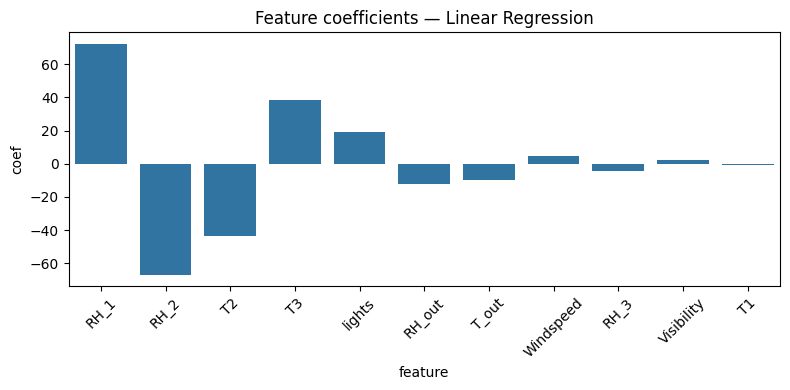

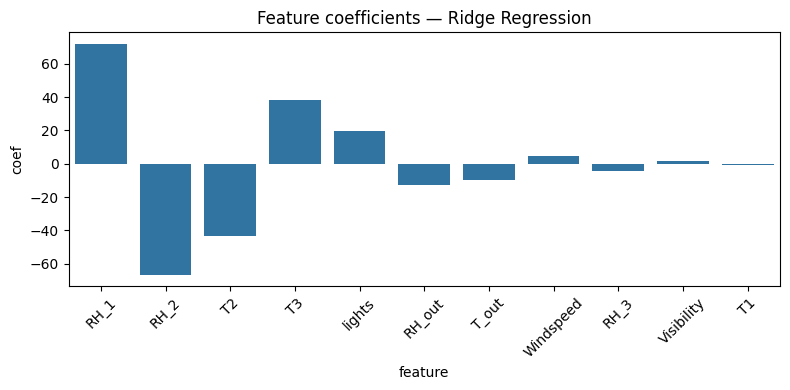

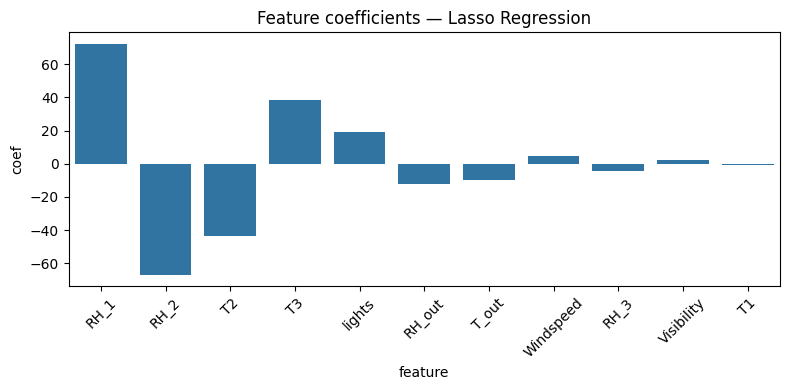

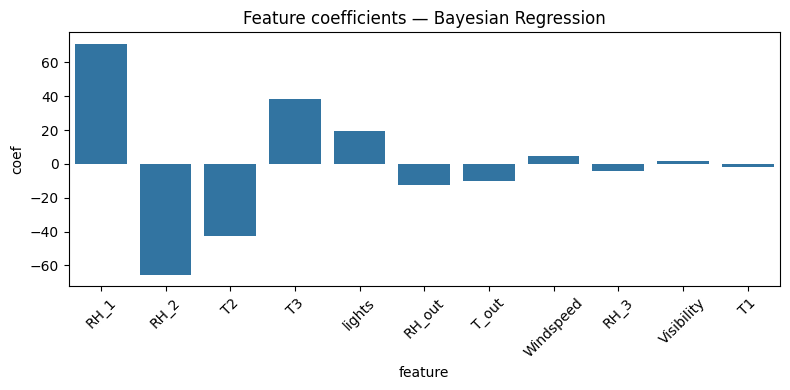

In [9]:
# Coefficient visualization (for models that expose coef_)
feature_names = features
for name, model in fitted.items():
    if hasattr(model, 'coef_'):
        coefs = model.coef_
        # Create dataframe for plotting
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
        coef_df = coef_df.sort_values('coef', key=abs, ascending=False)
        plt.figure(figsize=(8,4))
        sns.barplot(data=coef_df, x='feature', y='coef')
        plt.title(f'Feature coefficients — {name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 7) Predictions: Actual vs Predicted (best model)

Best model by R2: Bayesian Regression


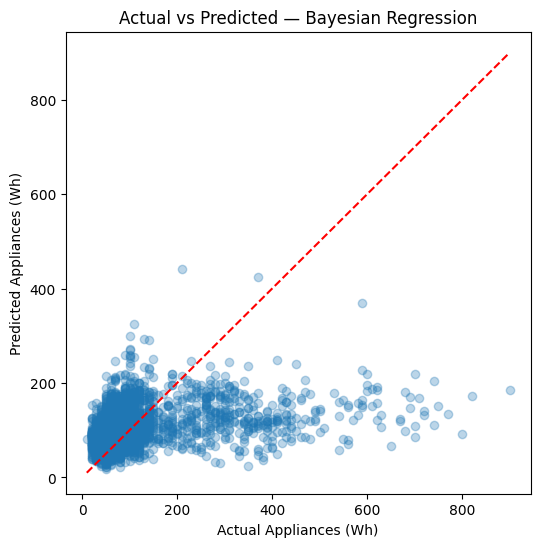

In [10]:
# Actual vs Predicted for the best model by R2
best_model_name = results_df.iloc[0]['Model']
print('Best model by R2:', best_model_name)
y_pred_best = preds[best_model_name]

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Appliances (Wh)')
plt.ylabel('Predicted Appliances (Wh)')
plt.title(f'Actual vs Predicted — {best_model_name}')
plt.show()

## 8) Save models (optional)

In [11]:
# Save the models and scaler (optional)
import joblib
joblib.dump(fitted, 'fitted_models.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Saved fitted models to fitted_models.pkl and scaler to scaler.pkl')

Saved fitted models to fitted_models.pkl and scaler to scaler.pkl


## Conclusion & Next steps

**What we did**
- Downloaded `energydata_complete.csv` from UCI.
- Performed EDA, selected features, standardized inputs.
- Trained and compared Linear, Ridge, Lasso, and Bayesian regression models.
- Evaluated using R², RMSE, and MAE, and visualized coefficients.

**Next steps / Improvements**
- Expand feature set (use all available sensor readings).
- Use cross-validation to tune regularization strength (`alpha`) for Ridge/Lasso (e.g., `GridSearchCV`).
- Try non-linear models (Random Forests, XGBoost) or time-series approaches if temporal patterns are important.
- Analyze residuals for heteroscedasticity and model assumptions.

---

**How to run**
1. Open this notebook in Jupyter or upload to Google Colab.
2. Run cells top-to-bottom. If you're on Colab, uncomment the pip install line to ensure dependencies are present.
3. The notebook saves the dataset locally and writes `fitted_models.pkl` and `scaler.pkl` in the working directory.